In [22]:
# # Sélection de variables avec la méthode LASSO
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.linear_model import Lasso, LassoCV
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
import seaborn as sns

In [5]:
import requests

url = "https://raw.githubusercontent.com/linogaliana/python-datascientist/main/content/modelisation/get_data.py"
r = requests.get(url, allow_redirects=True)
open("getdata.py", "wb").write(r.content)

import getdata

votes = getdata.create_votes_dataframes()
print(list(votes.columns))
votes.head(1)

['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER', 'geometry', 'FIPS_x', 'state_name', 'county_fips', 'county_name', 'votes_gop', 'votes_dem', 'total_votes', 'diff', 'per_gop', 'per_dem', 'per_point_diff', 'FIPS_y', 'State', 'Area_Name', 'Rural-urban_Continuum Code_2003', 'Rural-urban_Continuum Code_2013', 'Urban_Influence_Code_2003', 'Urban_Influence_Code_2013', 'Economic_typology_2015', 'CENSUS_2010_POP', 'ESTIMATES_BASE_2010', 'POP_ESTIMATE_2010', 'POP_ESTIMATE_2011', 'POP_ESTIMATE_2012', 'POP_ESTIMATE_2013', 'POP_ESTIMATE_2014', 'POP_ESTIMATE_2015', 'POP_ESTIMATE_2016', 'POP_ESTIMATE_2017', 'POP_ESTIMATE_2018', 'POP_ESTIMATE_2019', 'N_POP_CHG_2010', 'N_POP_CHG_2011', 'N_POP_CHG_2012', 'N_POP_CHG_2013', 'N_POP_CHG_2014', 'N_POP_CHG_2015', 'N_POP_CHG_2016', 'N_POP_CHG_2017', 'N_POP_CHG_2018', 'N_POP_CHG_2019', 'Births_2010', 'Births_2011', 'Births_2012', 'Births_2013', 'Births_2014', 'Births_2015', 'Births_2016', 'Births_2017', 'Births_2018', 

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,share_2008_democrat,share_2008_other,share_2008_republican,share_2012_democrat,share_2012_other,share_2012_republican,share_2016_democrat,share_2016_other,share_2016_republican,winner
0,29,227,00758566,0500000US29227,29227,Worth,06,690564983,493903,"POLYGON ((-94.63203 40.57176, -94.53388 40.570...",...,0.363714,0.034072,0.602215,0.325382,0.041031,0.633588,0.186424,0.041109,0.772467,republican


In [3]:
# # Analyse des variables prédictives du vote républicain:

# #     Retrait des variables de scores des concurrents (liées au score républicain) 
df2 = pd.DataFrame(votes.drop(columns="geometry"))
df2 = df2.loc[:,~df2.columns.str.endswith(
        ("_democrat", "_green", "_other", "winner", "per_point_diff", "per_dem")
    ),
]
df2 = df2.loc[:, ~df2.columns.duplicated()]
df2.head(1)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,FIPS_x,...,candidatevotes_2000_republican,candidatevotes_2004_republican,candidatevotes_2008_republican,candidatevotes_2012_republican,candidatevotes_2016_republican,share_2000_republican,share_2004_republican,share_2008_republican,share_2012_republican,share_2016_republican
0,29,227,00758566,0500000US29227,29227,Worth,06,690564983,493903,29227,...,651.0,691.0,707.0,664.0,808.0,0.562176,0.610424,0.602215,0.633588,0.772467


In [15]:
# # Exercice 1: 'per_gop': % vote républicain ('gop' = "Grand Old Party")

# # 1.1 Remplacer les infinis par des NaN
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

# # 1.2. Échantillon d'entraînement et échantillon test
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["per_gop"], axis=1), 100 * df2[["per_gop"]], test_size=0.2, random_state=0
)

# # 1.3. Création de pipeline pour l'imputation de valeurs numériques et catégorielles

# #     Sélction des variables numériques et catégorielles:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude=['number', 'datetime']).columns.tolist()  # on rajoute 'datetime' pour l'exemple

# #     Création des pipelines:
numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), ("scale", StandardScaler())]
)

categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("one-hot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("number", numeric_pipeline, numerical_features),
        ("category", categorical_pipeline, categorical_features),
    ]
)

# # 1.4. Estimateur LASSO:
model = Lasso(fit_intercept=True, alpha=0.1)

lasso_pipeline = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])
lasso_pipeline.fit(X_train, y_train)

# # 1.5. Affichage des coefficients:
# lasso1 = lasso_pipeline["model"]
lasso_model = lasso_pipeline["model"]
# Get feature names from the preprocessing step
features_preprocessing = lasso_pipeline['preprocess'].get_feature_names_out()
# Extract selected features based on non-zero coefficients
features_selec = pd.Series(features_preprocessing[np.abs(lasso_model.coef_) > 0])
features_selec



C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['POV04_2019' 'CI90LB04_2019' 'CI90UB04_2019' 'PCTPOV04_2019'
 'CI90LB04P_2019' 'CI90UB04P_2019']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


0                                         number__ALAND
1                                        number__FIPS_y
2                        number__INTERNATIONAL_MIG_2017
3                             number__DOMESTIC_MIG_2014
4                             number__DOMESTIC_MIG_2017
5                                 number__RESIDUAL_2010
6                                 number__RESIDUAL_2019
7                                  number__R_death_2012
8                                  number__R_death_2019
9                            number__R_NATURAL_INC_2019
10                     number__R_INTERNATIONAL_MIG_2011
11                          number__R_DOMESTIC_MIG_2012
12    number__Percent of adults with a bachelor's de...
13    number__Percent of adults with a high school d...
14    number__Percent of adults with a bachelor's de...
15    number__Percent of adults with a bachelor's de...
16              number__Rural_urban_continuum_code_2013
17                                   number__Met

In [16]:
# # 1.6. Corrélation entre les variables sélectionnées:
features_selected = features_selec.loc[
    features_selec.str.startswith("number__")
].str.replace("number__", "", regex=True)

corr = df2.loc[:, features_selected].corr()

plt.figure()
p = corr.style.background_gradient(cmap="coolwarm", axis=None).format("{:.2f}")
p

,ALAND,FIPS_y,INTERNATIONAL_MIG_2017,DOMESTIC_MIG_2014,DOMESTIC_MIG_2017,RESIDUAL_2010,RESIDUAL_2019,R_death_2012,R_death_2019,R_NATURAL_INC_2019,R_INTERNATIONAL_MIG_2011,R_DOMESTIC_MIG_2012,"Percent of adults with a bachelor's degree or higher, 1990","Percent of adults with a high school diploma only, 2000","Percent of adults with a bachelor's degree or higher, 2000","Percent of adults with a bachelor's degree or higher, 2015-19",Rural_urban_continuum_code_2013,Metro_2013,Unemployment_rate_2002,Unemployment_rate_2003,Unemployment_rate_2012,Rural-urban_Continuum_Code_2003,Rural-urban_Continuum_Code_2013,CI90LB517P_2019,candidatevotes_2016_republican,share_2012_republican,share_2016_republican
ALAND,1.00,-0.01,0.03,0.05,0.06,-0.02,0.12,-0.11,-0.12,0.10,-0.03,0.03,0.06,-0.17,0.04,-0.00,0.08,-0.08,0.06,0.05,0.02,0.08,0.08,0.01,0.11,0.03,-0.04
FIPS_y,-0.01,1.00,-0.04,0.01,0.01,-0.00,-0.05,0.01,-0.03,0.01,-0.00,0.11,0.03,0.01,0.03,0.04,0.01,-0.01,-0.01,-0.01,-0.20,0.01,0.01,-0.09,-0.06,0.05,0.05
INTERNATIONAL_MIG_2017,0.03,-0.04,1.00,-0.28,-0.56,-0.15,0.27,-0.19,-0.17,0.15,0.44,0.05,0.27,-0.25,0.26,0.27,-0.22,0.20,0.01,-0.01,0.00,-0.22,-0.22,-0.00,0.66,-0.23,-0.29
DOMESTIC_MIG_2014,0.05,0.01,-0.28,1.00,0.84,-0.05,0.10,-0.02,-0.03,-0.01,-0.10,0.16,0.01,-0.02,0.03,0.04,-0.03,0.04,-0.05,-0.06,-0.05,-0.03,-0.03,-0.11,-0.03,0.13,0.10
DOMESTIC_MIG_2017,0.06,0.01,-0.56,0.84,1.00,0.04,0.02,0.02,0.02,-0.05,-0.19,0.10,-0.05,0.04,-0.03,-0.02,-0.00,0.01,-0.04,-0.05,-0.02,0.00,-0.00,-0.10,-0.21,0.16,0.15
RESIDUAL_2010,-0.02,-0.00,-0.15,-0.05,0.04,1.00,0.09,-0.06,-0.07,0.09,-0.03,0.03,-0.03,-0.02,-0.03,-0.02,0.01,-0.01,0.02,0.02,0.01,0.01,0.01,0.03,-0.15,0.02,0.02
RESIDUAL_2019,0.12,-0.05,0.27,0.10,0.02,0.09,1.00,-0.06,-0.06,0.05,0.08,0.07,0.03,-0.09,0.03,0.02,-0.02,0.03,0.01,-0.00,0.02,-0.02,-0.02,0.01,0.27,0.02,-0.01
R_death_2012,-0.11,0.01,-0.19,-0.02,0.02,-0.06,-0.06,1.00,0.75,-0.62,-0.33,-0.11,-0.49,0.43,-0.50,-0.47,0.46,-0.41,0.14,0.16,0.08,0.45,0.46,0.26,-0.28,0.22,0.38
R_death_2019,-0.12,-0.03,-0.17,-0.03,0.02,-0.07,-0.06,0.75,1.00,-0.81,-0.35,-0.12,-0.49,0.42,-0.50,-0.47,0.28,-0.29,0.30,0.31,0.32,0.28,0.28,0.38,-0.22,0.07,0.23
R_NATURAL_INC_2019,0.10,0.01,0.15,-0.01,-0.05,0.09,0.05,-0.62,-0.81,1.00,0.32,0.11,0.31,-0.35,0.30,0.27,-0.24,0.22,-0.21,-0.22,-0.28,-0.24,-0.24,-0.18,0.18,-0.04,-0.19


<Figure size 640x480 with 0 Axes>

In [19]:
# # 1.7. Comparaison de performance avec un modèle ayant plus de variables:
def print_regression_metrics(y_true, y_pred, model_name=""):
    """
    Print RMSE and R^2 for regression analysis.

    Parameters:
    - y_true (array-like): The true target values.
    - y_pred (array-like): The predicted target values.
    - model_name (str): Name of the regression model. Default is an empty string.
    """
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    rsq = r2_score(y_true, y_pred)

    print(f"{model_name} Regression:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2: {rsq:.4f}")

    return rmse, rsq


# #     Régression parcimonieuse
lasso_pipeline = Pipeline(
    steps=[
        (
            "preprocess",
            ColumnTransformer(
                transformers=[("number", numeric_pipeline, numerical_features)]
            ),
        ),
        ("model", Lasso()),
    ]
)

lasso_pipeline.fit(X_train, y_train)

y_pred_parci = lasso_pipeline.predict(X_test)
rmse_parci, rsq_parci = print_regression_metrics(
    y_test, y_pred_parci, "Régression parcimonieuse"
)


# #     Régression non parcimonieuse
ols_pipeline = Pipeline(
    steps=[
        (
            "preprocess",
            ColumnTransformer(
                transformers=[("number", numeric_pipeline, numerical_features)]
            ),
        ),
        ("scaler", StandardScaler()),  # Add scaling for LinearRegression
        ("model", LinearRegression()),
    ]
)

ols_pipeline.fit(X_train, y_train)

y_pred_nonparci = ols_pipeline.predict(X_test)

rmse_nonparci, rsq_nonparci = print_regression_metrics(
    y_test, y_pred_nonparci, "Régression non parcimonieuse"
)

df_comp = pd.DataFrame(
    {
        "parcimonieux": [rmse_parci, rsq_parci, len(features_selected)],
        "non parcimonieux": [
            rmse_nonparci,
            rsq_nonparci,
            ols_pipeline[-1].coef_.shape[1] + 1,
        ],
    },
    index=["RMSE", "R2", "Nombre de paramètres"],
)
df_comp

C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['POV04_2019' 'CI90LB04_2019' 'CI90UB04_2019' 'PCTPOV04_2019'
 'CI90LB04P_2019' 'CI90UB04P_2019']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['POV04_2019' 'CI90LB04_2019' 'CI90UB04_2019' 'PCTPOV04_2019'
 'CI90LB04P_2019' 'CI90UB04P_2019']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warning

Régression parcimonieuse Regression:
RMSE: 2.7036
R^2: 0.9727
Régression non parcimonieuse Regression:
RMSE: 2.3090
R^2: 0.9801


C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['POV04_2019' 'CI90LB04_2019' 'CI90UB04_2019' 'PCTPOV04_2019'
 'CI90LB04P_2019' 'CI90UB04P_2019']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,parcimonieux,non parcimonieux
RMSE,2.703622,2.309011
R2,0.972728,0.980108
Nombre de paramètres,27.000000,332.000000


C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['POV04_2019' 'CI90LB04_2019' 'CI90UB04_2019' 'PCTPOV04_2019'
 'CI90LB04P_2019' 'CI90UB04P_2019']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2873.8446227479726, tolerance: 1116.0180221013902
  model = cd_fast.enet_coordinate_descent_multi_task(


coefs_lasso: [[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.25420029e-01
    3.20095831e-01  2.84237757e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  7.66719212e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    1.44150153e+00  6.22549531e+00]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   -1.08922628e-01 -1.80804435e-01]
  [ 2.82252500e-01  5.94165832e-01  1.16394256e+00 ...  2.78487955e+00
    2.94899149e+00  3.03523501e+00]
  [ 1.40950918e+01  1.38866604e+01  1.34005590e+01 ...  1.22966530e+01
    1.22697630e+01  1.21685168e+01]]]


C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3171539.7426079144, tolerance: 1116.0180221013902
  model = cd_fast.enet_coordinate_descent_multi_task(


[Text(0.5, 1.0, 'Number variables and regularization parameter ($\\alpha$)'),
 Text(0.5, 0, '$\\alpha$'),
 Text(0, 0.5, 'Nb. de variables')]

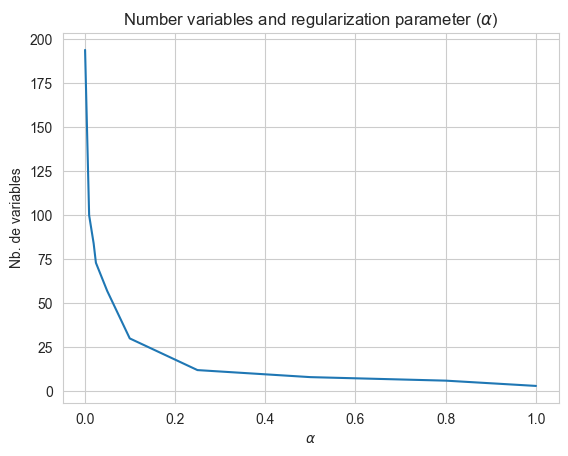

In [21]:
# # Exercice 2: rôle de \alpha sur les variables sélectionnées

# #     Liste de paramètres \alpha:
my_alphas = np.array([0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0])

# #     Séparation des données entrainement et test:
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["per_gop"], axis=1), 100 * df2[["per_gop"]], test_size=0.2, random_state=0
)

numerical_features = X_train.select_dtypes(include="number").columns.tolist()
categorical_features = X_train.select_dtypes(exclude=['number', 'datetime']).columns.tolist()

numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), ("scale", StandardScaler())]
)
preprocessed_features = pd.DataFrame(
    numeric_pipeline.fit_transform(X_train.drop(columns=categorical_features))
)

alpha_for_path, coefs_lasso, _ = lasso_path(
    preprocessed_features, y_train, alphas=my_alphas
)
print('coefs_lasso: {}'.format(coefs_lasso))
      
nb_non_zero = np.apply_along_axis(func1d=np.count_nonzero, arr=coefs_lasso, axis=0)
nb_non_zero = pd.DataFrame(nb_non_zero).sum(axis=0)

# graphique

sns.set_style("whitegrid")
plt.figure()
p = sns.lineplot(y=nb_non_zero, x=alpha_for_path)
p.set(
    title=r"Number variables and regularization parameter ($\alpha$)",
    xlabel=r"$\alpha$",
    ylabel="Nb. de variables",
)


In [24]:
# # Validation croisée pour extraction du \alpha optimal et relance du pipeline:

my_alphas = np.array([0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0])

lcv = LassoCV(alphas=my_alphas, fit_intercept=False, random_state=0, cv=5).fit(
    preprocessed_features, y_train
)

print("alpha optimal :", lcv.alpha_)

# # Relance du pipeline:
numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), ("scale", StandardScaler())]
)

categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("one-hot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("number", numeric_pipeline, numerical_features),
        ("category", categorical_pipeline, categorical_features),
    ]
)

model = Lasso(fit_intercept=False, alpha=lcv.alpha_)

lasso_pipeline = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])

lasso_optimal = lasso_pipeline.fit(X_train, y_train)

lasso_model = lasso_pipeline["model"]
# Get feature names from the preprocessing step
features_preprocessing = lasso_pipeline['preprocess'].get_feature_names_out()
# Extract selected features based on non-zero coefficients
features_selec2 = pd.Series(features_preprocessing[np.abs(lasso_model.coef_) > 0])
features_selec2

C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125854.20245944336, tolerance: 896.6050704948441
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1146303.875180583, tolerance: 896.6050704948441
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dmarin\AppD

alpha optimal : 1.0


C:\Users\dmarin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['POV04_2019' 'CI90LB04_2019' 'CI90UB04_2019' 'PCTPOV04_2019'
 'CI90LB04P_2019' 'CI90UB04P_2019']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


0                                  number__R_birth_2017
1     number__Percent of adults with less than a hig...
2     number__Percent of adults completing some coll...
3     number__Percent of adults with a bachelor's de...
4     number__Percent of adults with a high school d...
5     number__Percent of adults with a bachelor's de...
6                                number__CI90LBINC_2019
7                number__candidatevotes_2016_republican
8                         number__share_2008_republican
9                         number__share_2012_republican
10                        number__share_2016_republican
11                                 category__STATEFP_22
12                                    category__LSAD_06
13                                    category__LSAD_15
14                       category__state_name_Louisiana
dtype: object